In [319]:
# This class ensures that the FSM loaded from the CSV file has a correct amount of transitions.
class FSMFileTransitionsError(Exception):
    
    def __init__(self, list_of_states):
        print("States of the following unique IDs have an amount of 'possible discrete actions (transitions)' that is not equal to the amount of transitions in their 'Transition names' field.")
        print(*list_of_states)
        print("Please recheck the states and try again.")

In [320]:
# This class ensures that the FSM loaded from the CSV file has a correct amount of transitions.
class FSMStartStateNotFoundError(Exception):
    
    def __init__(self):
        print("No start states have been found in the CSV file!")
        print("Please recheck the file and set at least a single start state.")

In [321]:
class FSMTransitionStateNotFoundError(Exception):

    def __init__(self, unique_id):
        print("The transition to a state of the unique ID: {} has failed due to the state not being found in the CSV file!".format(unique_id))
        print("If this was not expected, please check the CSV file.")

In [322]:
class FSMIncorrectPresetStartStateError(Exception):

    def __init__(self, unique_id):
        print("The provided preset start state of the unique ID {} has not been found, or is not set as a start state.".format(unique_id))
        print("Please change the preset ID or set the state to be a start state in the CSV file.")

In [323]:
import pandas

def convert_state_names(file_name):
    df = pandas.read_csv(file_name)

    if 'Discretized_state_name' not in df.columns:
        state_names_dict = {}
        counter = 1
        for row in df.itertuples(index=False):
            print(row)
            if row.State_name not in state_names_dict:
                state_names_dict[row.State_name] = counter
                print(state_names_dict[row.State_name])
                counter += 1
        
        df['Discretized_state_name'] = df['State_name'].map(state_names_dict)
        df.to_csv(file_name, index=False)

    else:
        print('INFO: The CSV file provided already contains discretized state names.')

In [324]:
convert_state_names('pelican.csv')

INFO: The CSV file provided already contains discretized state names.


In [325]:
import numpy as np
import gym
import random
from csv import DictReader

class FSMEnv(gym.Env):
  """
  Custom Environment that follows gym interface.
  This is a simple env where the agent must learn how to traverse through a FSM in a CSV file. 
  """
  # If using google colab, GUI cannot be implemented ('human' render mode)
  # metadata = {'render.modes': ['console']}

  def __init__(self, file_name, start_state_id=None):
    super(FSMEnv, self).__init__()

    # The name of the .csv file containing the FSM
    self.file_name = file_name
    self.start_state_id = start_state_id
    self.randomize_start_state = False
    self.start_states = []

    convert_state_names(file_name)

    if start_state_id is None:
      preset_start_state = False

    elif int(start_state_id) == 0:
      preset_start_state = False
      self.randomize_start_state = True

    else:
      preset_start_state = True
      self.start_state_id = int(start_state_id)

      with open(self.file_name, 'r') as csv_file:
        correct_preset_start_state = False
        # pass the file object to DictReader() to get the DictReader object
        csv_dict_reader = DictReader(csv_file)

        # iterate over each line as a ordered dictionary
        for row in csv_dict_reader:
          # row variable is a dictionary that represents a row in csv
          if int(row['Unique_ID']) == self.start_state_id:
            if row['Start_state'] == '1':
              correct_preset_start_state = True
        
        if correct_preset_start_state == False:
          raise FSMIncorrectPresetStartStateError(self.start_state_id)

    if preset_start_state == False:
      start_state_already_set = False
      multiple_start_states = False

      with open(self.file_name, 'r') as csv_file:
        # pass the file object to DictReader() to get the DictReader object
        csv_dict_reader = DictReader(csv_file)

        # iterate over each line as a ordered dictionary
        for row in csv_dict_reader:
          # row variable is a dictionary that represents a row in csv
          if row['Start_state'] == '1':
            self.start_states.append(int(row['Unique_ID']))
            
            if start_state_already_set == False:
              start_state_already_set = True
              self.start_state_id = int(row['Unique_ID'])
            else:
              self.start_state_id = None
              multiple_start_states = True
      
        if multiple_start_states == True and self.randomize_start_state == False:
          print("Multiple start states have been found!")
          correct_start_state_provided = False

          while correct_start_state_provided == False:
            print("Please choose one of the found start states:")
            for unique_id in self.start_states:
              print(unique_id)
              
            print("Or input 0 to randomize the start state at each reset of the environment.")

            self.start_state_id = int(input("Provide an unique ID: "))
            
            if self.start_state_id not in self.start_states:
              if self.start_state_id == 0:
                self.randomize_start_state = True
                correct_start_state_provided = True
              else:
                print("ID provided is not in the list!")
            
            else:
              correct_start_state_provided = True

      if start_state_already_set == False:
        raise FSMStartStateNotFoundError()
        
    if self.randomize_start_state == True:
      self.start_state_id = random.choice(self.start_states)

    self.row_counter = 0

    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions, we have two: left and right
    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)
      broken_states = []
      broken_states_exist = False

      for row in csv_dict_reader:
        self.row_counter += 1

        if len(row['Transitions_to_states'].split()) != int(row['Possible_discrete_actions_(transitions)']):
          broken_states_exist = True
          broken_states.append(row['Unique_ID'])

        if int(row['Unique_ID']) == self.start_state_id:
          initial_actions = int(row['Possible_discrete_actions_(transitions)'])
          self.action_space = gym.spaces.Discrete(initial_actions)
          self.transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
    
    if broken_states_exist == True:
      raise FSMFileTransitionsError(broken_states)

    self.transitions_to_states.resize((self.row_counter + 1,))
    # print("Initialized transitions:", self.transitions_to_states)

    # These variables are initialized here in case of forgetting to use reset() before stepping through/predicting
    self.past_discretized_states = np.zeros((self.row_counter,), dtype=np.int64)
    self.past_unique_id_states = np.zeros((self.row_counter,), dtype=np.int64)
    self.amount_of_states_visited = 0 # Counter for the past 2 arrays as well
    self.current_unique_id_state = self.start_state_id
    self.current_discretized_state = 0

    # For tracking and rendering (timesteps)
    # self.total_amount_of_states_visited = 0

    # if render_mode == 'visual':
    #   # Initialize a pydot graph here to ensure it's not reloaded in the render() function
        # self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
        # self.rendering_heatmap_dict = {}
        # self.rendering_start_node_drawn = False
    # else:
    #   self.rendering_graph = None

    # Dict observation space
    self.observation_space = gym.spaces.Dict(
    {
        # Current state obs, including 0
        'current_state': gym.spaces.Discrete(self.row_counter + 1),
        # Past states history obs
        # Unfortunately SB3 does not support np.uint64, so high=np.inf would give us a negative value - this had to be worked around by
        # asking numpy to give the maximum value a np.int64 can have
        # Also, we had to use int64 as SB3 does not support uint64 sadly
        'past_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.row_counter + 1,), dtype=np.int64),
        # Transitions to states ?
        'transitions_to_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.row_counter + 1,), dtype=np.int64),
        # Amount of states already visited (could be garbage data?)
        # Including 0 and 7
        'amount_of_states': gym.spaces.Discrete(self.row_counter + 2),
    })

    print(self.action_space)
    print(self.observation_space)
    print(self.observation_space['past_states'])
    print("Amount of rows: {}".format(self.row_counter))

  def reset(self):
    """
    Important: the observation must be a numpy array
    :return: (np.array) 
    """
    # Initialize the agent at the start state
    self.past_discretized_states = np.zeros((self.row_counter + 1,), dtype=np.int64)
    self.past_unique_id_states = np.zeros((self.row_counter + 1,), dtype=np.int64)
    self.amount_of_states_visited = 0 # Counter for the past 2 arrays as well

    if self.randomize_start_state == True:
      self.start_state_id = random.choice(self.start_states)
      # print("I am choosing random!", self.start_state_id)
    
    self.current_unique_id_state = self.start_state_id

    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)
      
      for row in csv_dict_reader:
        if self.start_state_id == int(row['Unique_ID']):
          self.current_discretized_state = int(row['Discretized_state_name'])
          self.transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
          self.transitions_to_states.resize((self.row_counter + 1,))
          # print("Transitions after reset: ", self.transitions_to_states)
          self.past_discretized_states[self.amount_of_states_visited] = int(row['Discretized_state_name'])
          self.past_unique_id_states[self.amount_of_states_visited] = int(row['Unique_ID'])
          # self.amount_of_states_visited = 1
          # Leaving it at 0 will be a bit untrue, but better for the reward.

    observation = {
      'current_state': self.current_discretized_state,
      'past_states': self.past_discretized_states,
      'transitions_to_states': self.transitions_to_states,
      'amount_of_states': self.amount_of_states_visited, 
    }

    # print(observation)
    return observation

  def step(self, action):
    # NEED TO STORE UNIQUE IDs AS A SEPARATE LIST (NOT OBS)
    # this is done tbh
    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)

      for row in csv_dict_reader:
        if int(row['Discretized_state_name']) == self.current_discretized_state:
          # The line below splits the string into a list that contains the unique IDs of states that are possible to transition to
          # from the current state, and uses the action discrete integer to choose a transition from the list.
          # The int() function just converts the string to an integer.
          self.current_unique_id_state = int(row['Transitions_to_states'].split()[action])
      
      new_state_successfully_found = False

      # NEED TO IMPLEMENT CURRENT_UNIQUE_ID_STATE
      # done as well ayyyy
      with open(self.file_name, 'r') as csv_file:
        csv_dict_reader = DictReader(csv_file)
        
        for row in csv_dict_reader:
          if int(row['Unique_ID']) == self.current_unique_id_state:
            new_state_successfully_found = True
            self.current_discretized_state = int(row['Discretized_state_name'])
            self.transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
            self.transitions_to_states.resize((self.row_counter + 1,))
            
            self.amount_of_states_visited += 1
            # self.total_amount_of_states_visited += 1

            if self.current_unique_id_state in self.past_unique_id_states:
              reward = 0
              done = True
              # print(self.past_unique_id_states)
              # print(self.start_state_id)

            else:
              reward = self.amount_of_states_visited
              done = False

            self.past_discretized_states[self.amount_of_states_visited] = int(row['Discretized_state_name'])
            self.past_unique_id_states[self.amount_of_states_visited] = int(row['Unique_ID'])
            
            actions = int(row['Possible_discrete_actions_(transitions)'])
            self.action_space = gym.spaces.Discrete(actions)
        
      if new_state_successfully_found == False:
        raise FSMTransitionStateNotFoundError(self.current_unique_id_state)

    info = {}

    observation = {
      'current_state': self.current_discretized_state,
      'past_states': self.past_discretized_states,
      'transitions_to_states': self.transitions_to_states,
      'amount_of_states': self.amount_of_states_visited, 
    }

    # if done:
    #   print("DONE: OBSERVATION: {}".format(observation))

    # print("Current ID: {} Action taken: {} Is done: {} Reward: {} Action space: {} Past states: {}".format(self.current_unique_id_state, action, done, reward, self.action_space, self.past_discretized_states))
    return observation, reward, done, info

  def render(self, mode='visual'):
    ### Need to implement this now - matplotlib with circles?
    # Pydot to the win! wooo
    # if mode == 'visual':
    #   if self.rendering_graph == None:
    #     raise Exception("Incorrect render mode (other than visual!) has been provided to the init function of the environment!")
    #   else:
    #     if self.rendering_start_node_drawn == False:
    #       start_state_successfully_found = False
    #       with open(self.file_name, 'r') as csv_file:
    #         csv_dict_reader = DictReader(csv_file)

    #         for row in csv_dict_reader:
    #           if int(row['Unique_ID']) == self.start_state_id:
    #             start_state_successfully_found = True
    #             self.rendering_graph.add_node(pydot.Node(name=self.start_state_id, label=row['Discretized_state_name'], style='filled', fillcolor='gold'))
    #             self.rendering_start_node_drawn = True
          
    #       if start_state_successfully_found == False:
    #         raise FSMIncorrectPresetStartStateError(self.start_state_id)
        
    #     else:
          
                
    #     # Get the rendering dict to store the amount of visits for each unique ID
    #     # Then divide by the amount of visits to states other than the start state
    #     # Color the start state yellow or sth  
    #     if self.total_amount_of_states_visited % 10 == 0:
    #       plt = Image()
    
    # elif mode == 'text':
    #   print("Current ID: {} Amount of states visited by this agent: {} Action space: {} Total amount of states visited: {}".format(self.current_unique_id_state, self.amount_of_states_visited, self.action_space, self.total_amount_of_states_visited))

    # else:
    #   raise NotImplementedError() 
      pass

  def close(self):
    pass

## Next up: Creating a wrapper to render the progress of the RL algorithm 

But first: The render function is used for demonstrating the progress of a trained model - and it's after a reset, as well as after one step: Try to make it render the predictions.
We can try to first train a RL-free algorithm, then render and see whether it works. After that we can move onto wrappers and callbacks and so on.

Callback - used for evaluation

Wrapper - "around the env"

Maybe add an EvalCallback to autosave best model?

In [326]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

# Render here
class FSMRenderingWrapper(gym.Wrapper):
  """
  :param env: (gym.Env) Gym environment that will be wrapped
  """
  def __init__(self, env):

    # Initialize the graph here
    self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
    self.rendering_heatmap_dict = {}
    self.num_timesteps = 0
    
    # Add a node and edge during step function
    # 

    # Store the amount of visits to a node
    # When drawing, convert that to RGB:
    
    # Node A: 30 visits
    # Node B: 1 visit

    # Node A: 255, 255, 255
    # Node B: 1, 1, 1

    # Call the parent constructor, so we can access self.env later
    super(FSMWrapper, self).__init__(env)
  
  def reset(self):
    """
    Reset the environment 
    """
    obs = self.env.reset()
    return obs

  def step(self, action):
    """
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    # Add 
    self.num_timesteps += 1

    if self.num_timesteps % 500 == 0:
      clear_output(wait=True)
      plt = Image(graph.create_png())
      display(plt)

    obs, reward, done, info = self.env.step(action)
    return obs, reward, done, info


In [327]:
from stable_baselines3.common.env_checker import check_env

env = FSMEnv('pelican.csv')
# If the environment doesn't follow the interface, an error will be thrown
# The observation returned by the `reset()` method does not match the given observation space
# TypeError: can't convert np.ndarray of type numpy.uint64. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.
# AttributeError: 'dict' object has no attribute 'flatten'
check_env(env, warn=True)

INFO: The CSV file provided already contains discretized state names.
Multiple start states have been found!
Please choose one of the found start states:
1
2
4
6
Or input 0 to randomize the start state at each reset of the environment.
Discrete(2)
Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Box(0, 9223372036854775807, (7,), int64)
Amount of rows: 6


# Sampling actions to check if the env works correctly

In [328]:
env = FSMEnv('pelican.csv')
env.reset()
for _ in range(6):
    env.step(env.action_space.sample()) # Sample a random action and step
env.close()

INFO: The CSV file provided already contains discretized state names.
Multiple start states have been found!
Please choose one of the found start states:
1
2
4
6
Or input 0 to randomize the start state at each reset of the environment.
Discrete(2)
Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Box(0, 9223372036854775807, (7,), int64)
Amount of rows: 6


# Making the env

In [329]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env

# Insta4ntiate the env
env = FSMEnv('pelican.csv', start_state_id=0)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

INFO: The CSV file provided already contains discretized state names.
Discrete(2)
Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Box(0, 9223372036854775807, (7,), int64)
Amount of rows: 6


# Training the agent

In [331]:
#Train the agent
# You are probably using a MlpPolicy instead of a MultiInputPolicy (cf doc)
# AttributeError: 'dict' object has no attribute 'flatten'
model = A2C('MultiInputPolicy', env, gamma=0.999, verbose=1).learn(50000)

Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.87     |
|    ep_rew_mean        | 6.51     |
| time/                 |          |
|    fps                | 504      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.305   |
|    explained_variance | 0.5      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.458    |
|    value_loss         | 19.5     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 4.53     |
|    ep_rew_mean        | 9.25     |
| time/                 |          |
|    fps                | 518      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/             

In [20]:
# Train the agent
# You are probably using a MlpPolicy instead of a MultiInputPolicy (cf doc)
# AttributeError: 'dict' object has no attribute 'flatten'
model = PPO('MultiInputPolicy', env, gamma=0.99, verbose=1).learn(50000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.11     |
|    ep_rew_mean     | 4.15     |
| time/              |          |
|    fps             | 963      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.47       |
|    ep_rew_mean          | 5.37       |
| time/                   |            |
|    fps                  | 779        |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02214811 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.677     |
|    explained_variance   | -0.0151    |
|    learning_rate        | 

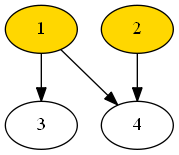

In [4]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)

graph.add_node(pydot.Node(name="1", style="filled", fillcolor="gold"))
graph.add_node(pydot.Node(name="2", style="filled", fillcolor="gold"))
graph.add_edge(pydot.Edge("1", "3"))
graph.add_edge(pydot.Edge("1", "4"))
graph.add_edge(pydot.Edge("2", "4"))
plt = Image(graph.create_png())
display(plt)

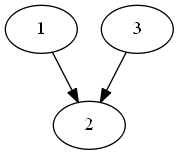

In [1]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)
graph.add_edge(pydot.Edge("1", "2"))
graph.add_edge(pydot.Edge("3", "2"))
plt = Image(graph.create_png())
display(plt)

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)
for i in range(2, 100):
    graph.add_edge(pydot.Edge("1", "{}".format(i)))
    graph.add_edge(pydot.Edge("{}".format(i-1), "{}".format(i)))
    if i % 50 == 0:
        print("Aaa")
        # plt = Image(graph.create_png())
        # display(plt)
        # clear_output(wait=True)
graph.write_png("Aaa.png")

In [ ]:
import gym

from stable_baselines3 import PPO

env = gym.make('CartPole-v0')

model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()

In [ ]:
env = GoLeftEnv(grid_size=10)

obs = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())

GO_LEFT = 0
# Hardcoded best agent: always go left!
n_steps = 20
for step in range(n_steps):
  print("Step {}".format(step + 1))
  obs, reward, done, info = env.step(GO_LEFT)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render()
  if done:
    print("Goal reached!", "reward=", reward)
    break

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break